In [1]:
import numpy as np
import pandas as pd
from methods import GuptaPPCA
from methods import GrassPPCA
from methods import KernelPPCA
from methods import binPCA
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

x = np.linspace(-1, 1, 100)
def F(a, b, c, d):
  return b*np.exp(-100*(x-a/2)**2) + c*np.exp(-100*(x+a/2)**2) + 1e-1*d*np.sin(np.pi*x)

def sampler(seed):
  np.random.seed(seed)
  a, b, c, d = 2*np.random.rand(4)-1
  u = F(a, b, c, d)
  return a, u

data = {'theta':[]}
data.update({'u%d' % (i+1):[] for i in range(len(x))})

for seed in range(500):
  a, u = sampler(seed)
  data['theta'].append(a)
  for i in range(len(x)):
    data['u%d' % (i+1)].append(u[i])

data = pd.DataFrame(data)
xdata = data.values[:,1:]
thetadata = data['theta'].values

data_test = {'theta':[]}
data_test.update({'u%d' % (i+1):[] for i in range(len(x))})

for seed in range(500):
  a, u = sampler(seed+500)
  data_test['theta'].append(a)
  for i in range(len(x)):
    data_test['u%d' % (i+1)].append(u[i])

data_test = pd.DataFrame(data_test)
xdata_test = data_test.values[:,1:]
thetadata_test = data_test['theta'].values

In [2]:
bin_tot = []
gamma_eq = []
bin_len = []
for i in range(1,10):
    temp_bin = np.linspace(-1, 1, i+1)
    bin_tot.append(temp_bin)
    bin_length = temp_bin[1] - temp_bin[0]
    bin_len.append(bin_length)
    gamma_eq.append(2/(bin_length**2))


In [3]:
rmse_PPCA = []
rmse_PCA = []
rmse_SPCA = []
rmse_binPCA = []
rmse_grass = []
rmse_test_PPCA = []
rmse_test_PCA = []
rmse_test_SPCA = []
rmse_test_binPCA = []
rmse_test_grass = []
rmse_ker = []
rmse_test_ker = []

In [4]:
for bins, gamma in zip(bin_tot,gamma_eq):
    print(f"length: {bins[1]-bins[0]}, gamma: {gamma}")
    m = 3

    # Standard PCA
    pca = PCA(n_components=m)
    data_red_PCA = pca.fit_transform(xdata)
    data_PCA = pca.inverse_transform(data_red_PCA)

    proj_test_PCA = pca.transform(xdata_test)
    data_test_PCA = pca.inverse_transform(proj_test_PCA)

    # Sparse PCA
    spca = SparsePCA(n_components=m).fit(xdata)
    spca_transf = spca.transform(xdata)
    data_SPCA = (spca_transf @ spca.components_) + spca.mean_

    proj_test_SPCA = spca.transform(xdata_test)
    data_test_SPCA = (proj_test_SPCA @ spca.components_) + spca.mean_

    # IPCA
    binpca = binPCA(bins,m)
    binpca.fit(thetadata,xdata)
    proj_binPCA = binpca.transform(thetadata,xdata)
    data_binPCA = binpca.inverse_transform(thetadata,proj_binPCA)

    proj_test_binPCA = binpca.transform(thetadata_test,xdata_test)
    data_test_binPCA = binpca.inverse_transform(thetadata_test,proj_test_binPCA)

    # PPCA
    gupta = GuptaPPCA(bins,m)
    gupta.fit(thetadata,xdata,maxiter=500,method="Powell")
    proj_PPCA = gupta.transform(thetadata,xdata)
    data_PPCA = gupta.inverse_transform(thetadata,proj_PPCA)

    proj_test_PPCA = gupta.transform(thetadata_test,xdata_test)
    data_test_PPCA = gupta.inverse_transform(thetadata_test,proj_test_PPCA)

    # Kernel PCA
    def kernel(theta_new, theta_i, gamma=gamma):
        return np.exp(-gamma*((theta_new-theta_i)**2))

    kerpca = KernelPPCA(thetadata,xdata,m, kernel)
    proj_ker = kerpca.transform(thetadata,xdata)
    data_ker = kerpca.inverse_transform(thetadata,proj_ker)

    proj_test_ker = kerpca.transform(thetadata_test,xdata_test)
    data_test_ker = kerpca.inverse_transform(thetadata_test,proj_test_ker)

    # Interpolation PCA
    grass = GrassPPCA(bins,m)
    grass.fit(thetadata,xdata)
    proj_grass = grass.transform(thetadata,xdata)
    data_grass = grass.inverse_transform(thetadata,proj_grass)

    proj_test_grass = grass.transform(thetadata_test,xdata_test)
    data_test_grass = grass.inverse_transform(thetadata_test,proj_test_grass)
    names = ['PCA','SPCA','binPCA','PPCA','Grass','Kernel']
    # for name,xrec in zip(names,[data_test_PCA, data_test_SPCA, data_test_IPCA, data_test_PPCA, data_test_grass, data_test_ker]):
    #     print("%s : %.4f" % (name,np.sqrt(mean_squared_error(xdata_test, xrec))))

    rmse_PCA.append(np.sqrt(mean_squared_error(xdata,data_PCA)))
    rmse_test_PCA.append(np.sqrt(mean_squared_error(xdata_test,data_test_PCA)))
    rmse_SPCA.append(np.sqrt(mean_squared_error(xdata,data_SPCA)))
    rmse_test_SPCA.append(np.sqrt(mean_squared_error(xdata_test,data_test_SPCA)))
    rmse_binPCA.append(np.sqrt(mean_squared_error(xdata,data_binPCA)))
    rmse_test_binPCA.append(np.sqrt(mean_squared_error(xdata_test,data_test_binPCA)))
    rmse_PPCA.append(np.sqrt(mean_squared_error(xdata,data_PPCA)))
    rmse_test_PPCA.append(np.sqrt(mean_squared_error(xdata_test,data_test_PPCA)))
    rmse_ker.append(np.sqrt(mean_squared_error(xdata,data_ker)))
    rmse_test_ker.append(np.sqrt(mean_squared_error(xdata_test,data_test_ker)))
    rmse_grass.append(np.sqrt(mean_squared_error(xdata,data_grass)))
    rmse_test_grass.append(np.sqrt(mean_squared_error(xdata_test,data_test_grass)))


length: 2.0, gamma: 0.5
length: 1.0, gamma: 2.0
length: 0.6666666666666666, gamma: 4.5
length: 0.5, gamma: 8.0
length: 0.4, gamma: 12.499999999999998
length: 0.33333333333333326, gamma: 18.000000000000007
length: 0.2857142857142857, gamma: 24.500000000000004
length: 0.25, gamma: 32.0
length: 0.2222222222222222, gamma: 40.5


In [5]:
# np.savez("resultsBinSizePowell.npz", n = 500, bin_len = bin_len, gamma_eq = gamma_eq, 
#          pcaTrain = rmse_PCA, pcaTest = rmse_test_PCA, spcaTrain = rmse_SPCA, spcaTest = rmse_test_SPCA, binpcaTrain = rmse_binPCA, binpcaTest = rmse_test_binPCA,
#          ppcaTrain = rmse_PPCA, ppcaTest = rmse_test_PPCA, grassmannTrain = rmse_grass, grassmannTest = rmse_test_grass, kernelTrain = rmse_ker, kernelTest = rmse_test_ker)

In [6]:
def forward(bin_len):
    return 2/(bin_len**2+1e-10)

def inverse(gamma_eq):
    return np.sqrt(2/(gamma_eq+1e-10))

def format_func(value, tick_number):
    return f"{value:.2f}"

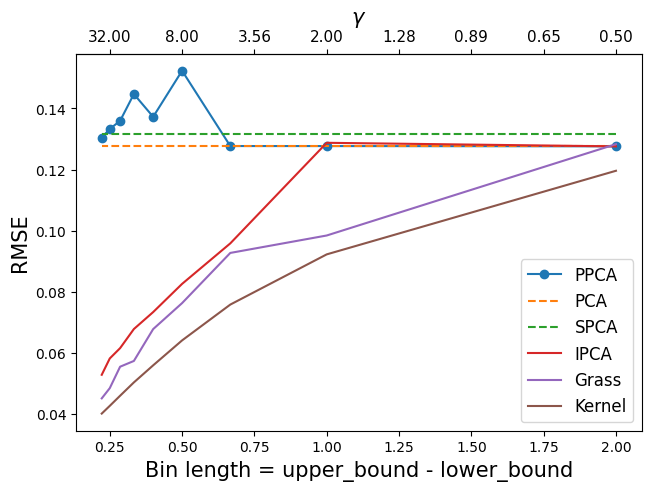

In [7]:
fig, ax = plt.subplots(constrained_layout=True)
plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
ax.plot(bin_len,rmse_test_PPCA,'o-', label="PPCA")
ax.plot(bin_len,rmse_test_PCA,'--', label="PCA")
ax.plot(bin_len,rmse_test_SPCA,'--', label="SPCA")
ax.plot(bin_len,rmse_test_binPCA, label="IPCA")
ax.plot(bin_len,rmse_test_grass, label="Grass")
ax.plot(bin_len,rmse_test_ker, label="Kernel")
ax.set_xlabel('Bin length = upper_bound - lower_bound',fontsize=15)
ax.set_ylabel('RMSE',fontsize=15)
# ax.set_title('Test RMSE opt. Nelder-Mead')
secax = ax.secondary_xaxis('top', functions=(forward, inverse))
secax.xaxis.set_major_formatter(FuncFormatter(format_func))
secax.set_xlabel('$\gamma$',fontsize=15)
wl_ticks = ax.get_xticks()
E_ticks = forward(wl_ticks)
secax.set_xticks(E_ticks)
plt.legend()
plt.show()

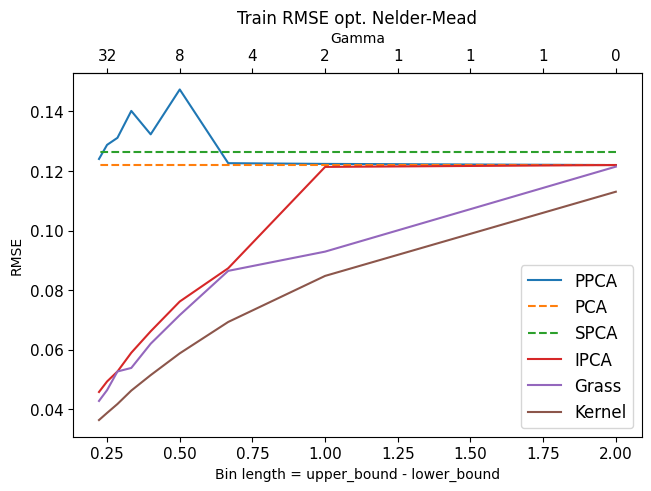

In [8]:
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(bin_len,rmse_PPCA, label="PPCA")
ax.plot(bin_len,rmse_PCA,'--', label="PCA")
ax.plot(bin_len,rmse_SPCA,'--', label="SPCA")
ax.plot(bin_len,rmse_binPCA, label="IPCA")
ax.plot(bin_len,rmse_grass, label="Grass")
ax.plot(bin_len,rmse_ker, label="Kernel")
ax.set_xlabel('Bin length = upper_bound - lower_bound')
ax.set_ylabel('RMSE')
ax.set_title('Train RMSE opt. Nelder-Mead')
secax = ax.secondary_xaxis('top', functions=(forward, inverse))
secax.set_xlabel('Gamma')
wl_ticks = ax.get_xticks()
E_ticks = forward(wl_ticks)
secax.set_xticks(E_ticks)
plt.legend()
plt.show()